In [1]:
import pandas as pd
import numpy as np
from cleantext import clean
import re
from transformers import XLNetTokenizer, XLNetForSequenceClassification, TrainingArguments, Trainer, pipeline
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import datasets
import evaluate
import random

Since the GPL-licensed package `unidecode` is not installed, using Python's `unicodedata` package which yields worse results.


# Process our data

In [2]:
data_train = pd.read_csv('./emotions_data/emotion-labels-train.csv')
data_test = pd.read_csv('./emotions_data/emotion-labels-test.csv')
data_val = pd.read_csv('./emotions_data/emotion-labels-val.csv')

In [3]:
data_train.head()

,text,label
0,Just got back from seeing @GaryDelaney in Burs...,joy
1,Oh dear an evening of absolute hilarity I don'...,joy
2,Been waiting all week for this game ❤️❤️❤️ #ch...,joy
3,"@gardiner_love : Thank you so much, Gloria! Yo...",joy
4,I feel so blessed to work with the family that...,joy


In [4]:
data = pd.concat([data_train, data_test, data_val], ignore_index=True)

In [5]:
data['text_clean'] = data['text'].apply(lambda x: clean(x, no_emoji=True))

In [6]:
data['text_clean'] = data['text_clean'].apply(lambda x: re.sub(r'@[^\s]+', '', x))

In [7]:
data.head(20)

,text,label,text_clean
0,Just got back from seeing @GaryDelaney in Burs...,joy,just got back from seeing in burslem. amazing...
1,Oh dear an evening of absolute hilarity I don'...,joy,oh dear an evening of absolute hilarity i don'...
2,Been waiting all week for this game ❤️❤️❤️ #ch...,joy,been waiting all week for this game #cheer #fr...
3,"@gardiner_love : Thank you so much, Gloria! Yo...",joy,": thank you so much, gloria! you're so sweet,..."
4,I feel so blessed to work with the family that...,joy,i feel so blessed to work with the family that...
5,"Today I reached 1000 subscribers on YT!! , #go...",joy,"today i reached 1000 subscribers on yt!! , #go..."
6,"@Singaholic121 Good morning, love! Happy first...",joy,"good morning, love! happy first day of fall. ..."
7,#BridgetJonesBaby is the best thing I've seen ...,joy,#bridgetjonesbaby is the best thing i've seen ...
8,Just got back from seeing @GaryDelaney in Burs...,joy,just got back from seeing in burslem. amazing...
9,@IndyMN I thought the holidays could not get a...,joy,i thought the holidays could not get any more...


<Axes: xlabel='label'>

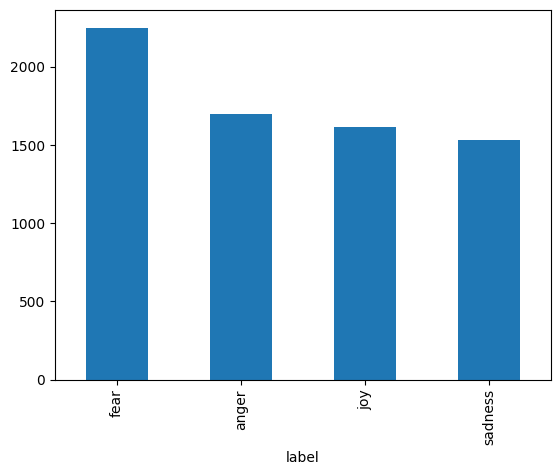

In [8]:
data['label'].value_counts().plot(kind="bar")

<Axes: xlabel='label'>

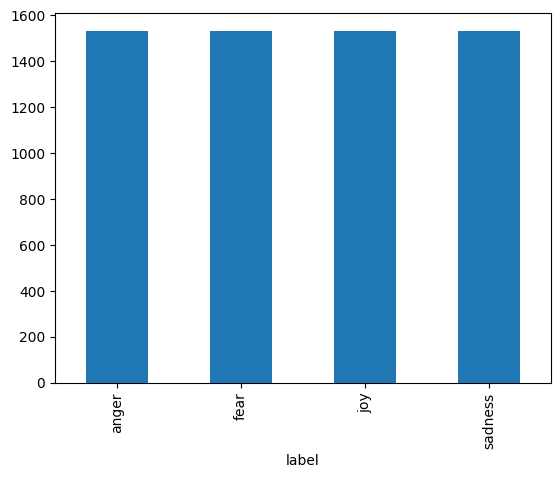

In [9]:
g = data.groupby('label')

data = g.apply(
    lambda x: x.sample(g.size().min())
).reset_index()

# If the label is currently renamed to level_0, change it back.
if 'label' not in data.columns:
    if 'level_0' in data.columns:
        data = data.rename(columns={'level_0': 'label'})

# Drop any redundant index columns if present
if 'level_1' in data.columns:
    data = data.drop(columns=['level_1'])

data['label'].value_counts().plot(kind='bar')

In [10]:
data['label_int'] = LabelEncoder().fit_transform(data['label'])

In [11]:
NUM_LABELS = 4

In [12]:
train_split, test_split = train_test_split(data, train_size = 0.8)
train_split, val_split = train_test_split(train_split, train_size = 0.9)

In [13]:
print(len(train_split))
print(len(test_split))
print(len(val_split))

4414
1227
491


In [14]:
train_df = pd.DataFrame({
    'label': train_split.label_int.values,
    'text': train_split.text_clean.values
})

test_df = pd.DataFrame({
    'label': test_split.label_int.values,
    'text': test_split.text_clean.values
})

In [15]:
train_df = datasets.Dataset.from_dict(train_df)
test_df = datasets.Dataset.from_dict(test_df)

In [16]:
dataset_dict = datasets.DatasetDict({'train': train_df, 'test':test_df})

In [17]:
dataset_dict

DatasetDict({
    train: Dataset({
        features: ['label', 'text'],
        num_rows: 4414
    })
    test: Dataset({
        features: ['label', 'text'],
        num_rows: 1227
    })
})

# Create Embeddings

In [18]:
tokenizer = XLNetTokenizer.from_pretrained('xlnet-base-cased')

In [19]:
def tokenize_function(examples):
    return tokenizer(examples['text'], padding='max_length', max_length=128, truncation=True)

In [20]:
tokenized_datasets = dataset_dict.map(tokenize_function, batched=True)

Map:   0%|          | 0/4414 [00:00<?, ? examples/s]

Map:   0%|          | 0/1227 [00:00<?, ? examples/s]

In [21]:
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['label', 'text', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 4414
    })
    test: Dataset({
        features: ['label', 'text', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 1227
    })
})

In [22]:
print(tokenized_datasets['train']['text'][0])

 unfortunately the diet is still on, so they will have to wait till friday i'm afraid.


In [23]:
print(tokenized_datasets['train']['input_ids'][0])

[5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 13219, 18, 3663, 27, 194, 31, 19, 102, 63, 53, 47, 22, 2065, 6667, 17, 5994, 765, 17, 150, 26, 98, 4155, 9, 4, 3]


In [24]:
tokenizer.decode(5)

'<pad>'

In [25]:
print(tokenized_datasets['train']['token_type_ids'][0])

[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2]


In [26]:
print(tokenized_datasets['train']['attention_mask'][0])

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [27]:
small_train_dataset = tokenized_datasets['train'].shuffle(seed=42).select(range(100))
small_eval_dataset = tokenized_datasets['test'].shuffle(seed=42).select(range(100))

# Fine Tune our Model

In [28]:
model = XLNetForSequenceClassification.from_pretrained('xlnet-base-cased',
                                                       num_labels=NUM_LABELS,
                                                       id2label={0:'anger',1:'fear',2:'joy',3:'sadness'})

Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.bias', 'logits_proj.weight', 'sequence_summary.summary.bias', 'sequence_summary.summary.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [29]:
metric = evaluate.load('accuracy')

In [30]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis = -1)
    return metric.compute(predictions=predictions, references=labels)

In [31]:
training_args = TrainingArguments(output_dir='test_trainer', eval_strategy='epoch',num_train_epochs=3)

In [32]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=small_train_dataset,
    eval_dataset=small_eval_dataset,
    compute_metrics=compute_metrics)

trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,1.358792,0.320000
2,No log,1.358252,0.300000
3,No log,1.345443,0.340000


TrainOutput(global_step=39, training_loss=1.3161165286333134, metrics={'train_runtime': 448.6875, 'train_samples_per_second': 0.669, 'train_steps_per_second': 0.087, 'total_flos': 21366375321600.0, 'train_loss': 1.3161165286333134, 'epoch': 3.0})

# Evaluate Model

In [41]:
trainer.evaluate()

{'eval_loss': 1.3454432487487793,
 'eval_accuracy': 0.34,
 'eval_runtime': 34.5505,
 'eval_samples_per_second': 2.894,
 'eval_steps_per_second': 0.376,
 'epoch': 3.0}

In [46]:
model.save_pretrained('fine_tuned_model')

In [47]:
fine_tuned_model = XLNetForSequenceClassification.from_pretrained('fine_tuned_model')

In [48]:
clf = pipeline('text-classification', fine_tuned_model, tokenizer=tokenizer)

Device set to use cpu


In [51]:
rand_int = random.randint(0, len(val_split) - 1)
test_text = val_split['text_clean'].iloc[rand_int]
answer = clf(test_text, top_k = None)
print(f"Result: {answer}")

Result: [{'label': 'joy', 'score': 0.3647151589393616}, {'label': 'fear', 'score': 0.24849216639995575}, {'label': 'anger', 'score': 0.22891491651535034}, {'label': 'sadness', 'score': 0.15787768363952637}]


In [50]:
rand_int = random.randint(0, len(val_split) - 1)
test_text = val_split['text_clean'].iloc[rand_int]
answer = clf(test_text, top_k = None)
print(f"Result: {answer}")

Result: [{'label': 'joy', 'score': 0.4201403558254242}, {'label': 'fear', 'score': 0.2237648218870163}, {'label': 'anger', 'score': 0.19063931703567505}, {'label': 'sadness', 'score': 0.16545550525188446}]
